In [ ]:
"""This notebook has Python code I wrote for an Avito kaggle competition. I have placed it in this repository
simply to illustrate my ability to use tensorflow, keras, and pandas. The neural network, which utilized 
multiple LSTMs, is defined in this notebook in a function called define_model(). This notebook does not display 
any meaningful results for that competition as it is simply here to show my code."""

In [1]:
import os
import sys
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model,load_model
from keras import layers as L
from keras import optimizers as K_opt
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
import zipfile
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import lightgbm as lgbm
import GPyOpt
#from text_sequencing import *
import pandas as pd
from datetime import datetime, timedelta
from translate import Translator
from pymystem3 import Mystem
import time
import pickle
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import gc

sys.path.append(os.path.join(os.getcwd(),'neural-image-assessment-master'))
from path import Path
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input,decode_predictions
from keras.applications.vgg19 import VGG19,preprocess_input as VGG19_preprocess_input,decode_predictions as VGG19_decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from utils.score_utils import mean_score, std_score

#    num_classification_units = object_classification_model.layers[-1].units


C:\Users\ericz\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
"""
global variables
"""
ENGLISH_LETTERS = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P',\
                  'Q','R','S','T','U','V','W','X','Y','Z']


ENGLISH_LETTERS += list(map(lambda x: x.lower(),ENGLISH_LETTERS))

NUMERALS = ['0','1','2','3','4','5','6','7','8','9']

DECIMAL_REPLACEMENT_CHAR = '^'

#leaving out hyphen
PUNCTUATION_MARKS = '!"#$%&()*+,./:;<=>?^@[\]_`{|}~'
    
PUNCTUATION_MARKS = \
[p for p in PUNCTUATION_MARKS if p != DECIMAL_REPLACEMENT_CHAR]

#maximum lengths in tokens
DESCRIPTION_MAX_LEN = 50
TITLE_MAX_LEN = 10

AVITO_DATA_DIR = r'C:\Users\ericz\Documents\AvitoCompetition\data' 

OBJECT_CLASSIFICATION_SAVE_DIR = \
os.path.join(os.path.dirname(os.getcwd()),r'data\object_classifications')

NUM_OBJECT_CLASSES = 1000


In [3]:
def load_active_CSV(csv_path,nrows = None,skiprows = None):
    
    return pd.read_csv(csv_path,parse_dates = ['activation_date'],\
    date_parser = lambda x: pd.to_datetime(x,format = "%Y-%m-%d"),\
    nrows = nrows,skiprows = skiprows)

    
def load_main_CSV(csv_path,nrows = None):
    
    print('loading {:s}...'.format(csv_path))
    
    if (nrows is None):
    
        return pd.read_csv(csv_path,parse_dates = ['activation_date'],\
        date_parser = lambda x: pd.to_datetime(x,format = "%Y-%m-%d"),\
        dtype = {'item_id': str, 'user_id': str, 'region': str,\
        'city': str, 'parent_category_name': str, 'category_name': str,\
        'param_1': str, 'param_2': str, 'param_3': str,\
        'title': str,'description': str, 'price': np.float32, \
        'item_seq_number': np.int32,\
        'user_type': str, 'image': str, 'image_top_1': np.float32, \
        'deal_probability': np.float32})
        
    else:

        return pd.read_csv(csv_path,parse_dates = ['activation_date'],\
        date_parser = lambda x: pd.to_datetime(x,format = "%Y-%m-%d"),\
        nrows = nrows,\
        dtype = {'item_id': str, 'user_id': str, 'region': str,\
        'city': str, 'parent_category_name': str, 'category_name': str,\
        'param_1': str, 'param_2': str, 'param_3': str,\
        'title': str,'description': str, 'price': np.float32, \
        'item_seq_number': np.int32,\
        'user_type': str, 'image': str, 'image_top_1': np.float32, \
        'deal_probability': np.float32})
    
    
def start_up(load_CSV_only_flag = False,\
    word_to_glove_vec = None,embedding_layers_dict = None):
    """
    Performs steps required prior to training any models.
    
    """

    #load processed competition CSV
    net_CSV_path = os.path.join(AVITO_DATA_DIR,'processed_net.csv')

    net_CSV = load_main_CSV(net_CSV_path)

    print("loaded net_CSV")

    if (load_CSV_only_flag):

        return net_CSV
        
    #create logical arrays representing training and validation records of competition train CSV
    tr_val_log_dict = return_training_and_validation_logical_dict(net_CSV)
    
    print("# training records = {:d}".format(tr_val_log_dict['training_logical'].sum()))
    print("# validation records = {:d}".format(tr_val_log_dict['validation_logical'].sum()))
    print("# test records = {:d}".format(tr_val_log_dict['test_logical'].sum()))
    print("total # records in net_CSV = {:d}".format(net_CSV.shape[0]))
    print("% of total train CSV records comprising validation = {:.1f}".format(\
    100*tr_val_log_dict['validation_logical'].sum()/(\
    tr_val_log_dict['training_logical'].sum() + tr_val_log_dict['validation_logical'].sum())))
    
    #load pre-trained word-to-glove vector dict
    if (word_to_glove_vec is None):
        word_to_glove_vec = return_word2glovevec_dict(\
        glove_filename = \
        r"C:\Users\ericz\Documents\AvitoCompetition\data\ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize-002.vec")
    
    #create dictionary with tokenizers for LSTMs
    LSTM_tokenizer_dict = {}

    columns_to_tokenize = ['description_processed','title_processed']
    
    for column_to_tokenize in columns_to_tokenize:

        if False:

            #train a tokenizer on 'description_processed' field using training records from train_CSV
            #(does not need to be redone if tokenizer was previously saved to file)
            tokenizer = tokenizer_for_LSTM(net_CSV,column_to_tokenize,tr_val_log_dict)

        else:

            tokenizer_file_name = \
            os.path.join(r'C:\Users\ericz\Documents\AvitoCompetition\data',column_to_tokenize + '_tokenizer.pkl')

            if False:
                with open(tokenizer_file_name,mode = 'wb') as tokenizer_fobj:
                    pickle.dump(tokenizer, tokenizer_fobj)
                    del tokenizer
            else:
                with open(tokenizer_file_name,mode = 'rb') as tokenizer_fobj:
                    tokenizer = pickle.load(tokenizer_fobj)

                    LSTM_tokenizer_dict[column_to_tokenize] = tokenizer
                    
    if (embedding_layers_dict is None):                
        #create keras embedding layers using pre-trained word vectors
        embedding_layers_dict = {}

        embedding_layers_dict['description_processed'] = pretrained_embedding_layer(\
        word_to_vec_map = word_to_glove_vec, tokenizer = LSTM_tokenizer_dict['description_processed'])

        embedding_layers_dict['title_processed'] = pretrained_embedding_layer(\
        word_to_vec_map = word_to_glove_vec, tokenizer = LSTM_tokenizer_dict['title_processed'])
    
    #train tokenizers for non-LSTM fields using training records from net_CSV
    tokenizer_dict,one_hot_encoder_dict = \
    tokenizers_and_onehot_encoders_from_othercolumns(net_CSV,tr_val_log_dict)

    #does not need to be redone
    if False:
        apply_tokenizers_to_db(net_CSV,tokenizer_dict)
        
    print("Done.")

    return net_CSV,tr_val_log_dict,word_to_glove_vec,\
    LSTM_tokenizer_dict,embedding_layers_dict,tokenizer_dict,one_hot_encoder_dict

        


In [116]:
def load_NIMA():
    """
    Returns pre-trained keras NIMA model. Sets inpout shape to (224,224)
    """

    with tf.device('/cpu:0'):

        base_model = InceptionResNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights=None)

        x = L.Dropout(0.75)(base_model.output)

        x = L.Dense(10, activation='softmax')(x)

        model = Model(base_model.input, x)

        model.load_weights('neural-image-assessment-master/weights/inception_resnet_weights.h5')

    return model


def NIMA_predict(img_paths,NIMA_model,batch_size):
    """
    Returns a list of (mean,SD) tuples of NIMA predictions 
    for a list of image paths. Returns np.nan
    for both mean and SD if image path is None. All images
    will be resized to (224,224).
    
    img_paths: list of image full paths
    
    NIMA_model: pretrained keras model
    
    batch_size: batch size for model prediction
    
    """

    target_size = (224, 224)
    
    score_list = []
    
    img_exists_list = []
    
    x_list = []
    
    for idx,img_path in enumerate(img_paths):
        
        if (img_path is None):
            
            img_exists_list.append(False)
            
            continue
            
        else:
            
            try:
            
                img = load_img(img_path, target_size=target_size)
                
            except:
                
                img_exists_list.append(False)
            
                continue
                
            img_exists_list.append(True)
            
            x = img_to_array(img)

            #x = np.expand_dims(x, axis=0)

            x = preprocess_input(x)
            
            x_list.append(x) 

    if (len(x_list) > 0):
        
        scores = NIMA_model.predict(np.array(x_list), batch_size=batch_size, verbose=0)
        
    counter = 0
    for img_exists in img_exists_list:
        
        if (img_exists):
            mean = mean_score(scores[counter,:])
            std = std_score(scores[counter,:])
            counter += 1
        else:
            mean = np.nan
            std = np.nan
                        
        score_list.append((mean,std))

    return score_list


def add_NIMA_score_to_database(database, train_CSV_flag = True, \
    zip_obj = None,NIMA_model = None,batch_size = 10,break_at = 100,\
    save_interval = np.int(1E4),idx_start = 0,idx_end_exclusive = None):
    """
    Adds NIMA mean and SD (presumably uncertainty measure) fields to database.
    NIMA score is image quality score, generated using this software:
    https://github.com/titu1994/neural-image-assessment
    """
    
    start = time.clock()
    
    num_records = database.shape[0]
    
    if (zip_obj is None):
        #create zipfile object; this is slow, so do only once
        print("Creating zipfile object...")
        created_zip_obj_flag = True
        
        if (train_CSV_flag):
            zip_filename = r"C:\Users\ericz\Documents\AvitoCompetition\data\train_jpg.zip"
        else:
            zip_filename = r"C:\Users\ericz\Documents\AvitoCompetition\data\test_jpg.zip"
        
        zip_obj = zipfile.ZipFile(zip_filename,mode = 'r') 
        print("Done.")
    else:
        created_zip_obj_flag = False
    
    if (NIMA_model is None):
        #load pe-trained keras NIMA model
        print("Loading pre-trained keras model...")
        NIMA_model = load_NIMA()
        print("Done.")
    
    #add NIMA score fields to database if they do not already exist
    NIMA_score_fieldnames = ['NIMA_mean','NIMA_sd']
    
    print("Adding NIMA fieldnames to database...")
    for NIMA_score_fieldname in NIMA_score_fieldnames:
        
        if (NIMA_score_fieldname not in database.columns):
            database[NIMA_score_fieldname] = np.zeros((num_records,),dtype = np.float32)
    
    print("Done.")
    
    print("Starting computation of NIMA metrics...")
    
    if (idx_end_exclusive is None):
        idx_end_exclusive = num_records
    
    loop_range = range(idx_start,idx_end_exclusive)    
    
    idx_idx = 0
    for idx in tqdm(loop_range):
            
        if (idx_idx >= break_at):
            break
        
        if ((idx_idx % batch_size) == 0):
            
            counter = 0
            
            loaded_jpg_full_paths = []
        
            idx_storage = []

        jpg_id = database.loc[idx,'image']
        
        idx_storage.append(idx)
        
        #executes when no jpg file for the ad
        if (not(isinstance(jpg_id,str)) and np.isnan(jpg_id)):
            loaded_jpg_full_paths.append(None)
        else:
            loaded_jpg_full_paths.append(\
            extract_jpg_from_zipfileobject(zip_obj,jpg_id,verbose = False))
            
        if ((counter < batch_size - 1) and (idx < num_records - 1)):
            counter += 1
            idx_idx += 1
            continue
        else:
        
            #crnt_scores is a list of tuples, each tuple comprising (mean,SD) for corresponding image
            crnt_scores = \
            NIMA_predict(img_paths = loaded_jpg_full_paths,\
            NIMA_model = NIMA_model,batch_size = batch_size)

            for stored_idx_idx,stored_idx in enumerate(idx_storage):
                #crnt_score is a tuple (mean,SD)
                crnt_score = crnt_scores[stored_idx_idx]
                for NIMA_score_idx,NIMA_score_fieldname in enumerate(NIMA_score_fieldnames):
                    database.loc[stored_idx,NIMA_score_fieldname] = crnt_score[NIMA_score_idx]
                
                #delete image files from previous batch
                if (loaded_jpg_full_paths[stored_idx_idx] is not None):
                    os.remove(loaded_jpg_full_paths[stored_idx_idx])
                    
            if (((idx_idx + 1) % save_interval) == 0):

                if True:
                    database.to_csv(r'C:\Users\ericz\Documents\AvitoCompetition\data\processed_net.csv')
                elif (train_CSV_flag):
                    database.to_csv(r'C:\Users\ericz\Documents\AvitoCompetition\data\processed_train.csv')
                else:
                    database.to_csv(r'C:\Users\ericz\Documents\AvitoCompetition\data\processed_train.csv')

                note_obj = open(r'C:\Users\ericz\Documents\AvitoCompetition\data\NIMA_note.txt',mode = 'wt')
                note_obj.write("Last idx (inclusive) successfully saved at = {:d}.".format(idx))
                note_obj.close()
                
            idx_idx += 1

    #close zipfile object
    if (created_zip_obj_flag):
        zip_obj.close()
    
    time_elapsed_s = time.clock() - start
    
    print("Time elapsed  = {:.1f} seconds".format(time_elapsed_s))
    
    print("Done.")
    
    
def load_InceptionResNetV2():
    """
    Returns pre-trained keras InceptionResNetV2 model. Sets inpout shape to (299,299)
    """

    with tf.device('/cpu:0'):

        model = InceptionResNetV2(\
        include_top=True, weights='imagenet', input_tensor=None, \
        input_shape=None, pooling=None, classes=1000)

    return model


def load_VGG19():
    """
    Returns pre-trained keras VGG19 model. Sets inpout shape to (224,224)
    """

    with tf.device('/cpu:0'):

        model = VGG19(include_top=True, \
        weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
        
    return model


def object_predict(img_paths,object_classification_model,batch_size,target_size):
    """
    Returns a list of lists of obhect classification (softmax) vectors. Returns np.nan
    for both mean and SD if image path is None. All images
    will be resized to target_size.
    
    img_paths: list of image full paths
    
    object_classification_model: pretrained keras model
    
    batch_size: batch size for model prediction
    
    """

    classification_vectors_list = []
    
    img_exists_list = []
    
    x_list = []
    
    for idx,img_path in enumerate(img_paths):
        
        if (img_path is None):
            
            img_exists_list.append(False)
            
            continue
            
        else:
            
            try:
            
                img = load_img(img_path, target_size=target_size)
                
            except:
                
                img_exists_list.append(False)
            
                continue
                
            img_exists_list.append(True)
            
            x = img_to_array(img)

            #x = np.expand_dims(x, axis=0)

            x = VGG19_preprocess_input(x)
            
            x_list.append(x) 

    if (len(x_list) > 0):
        
        classification_vectors = object_classification_model.predict(np.array(x_list), batch_size=batch_size, verbose=0)
        
    counter = 0
    for img_exists in img_exists_list:
        
        if (img_exists):
            classification_vector = classification_vectors[counter]
            counter += 1
        else:
            classification_vector = np.nan
                        
        classification_vectors_list.append(classification_vector)

    return classification_vectors_list


def save_object_classification_vectors(database, tr_val_log_dict,\
    target_size, train_CSV_flag = True,\
    zip_obj = None,object_classification_model = None,batch_size = 10,break_at = 100,\
    idx_start = 0,idx_end_exclusive = None):
    """
    Saves object classification vector np.array as PKL file named with
    corresponding image_ID (obtained from input database).
    
    database: should be net_CSV database
    """
    
    start = time.clock()
    
    if (zip_obj is None):
        #create zipfile object; this is slow, so do only once
        print("Creating zipfile object...")
        created_zip_obj_flag = True
        
        if (train_CSV_flag):
            zip_filename = r"C:\Users\ericz\Documents\AvitoCompetition\data\train_jpg.zip"
        else:
            zip_filename = r"C:\Users\ericz\Documents\AvitoCompetition\data\test_jpg.zip"
        
        zip_obj = zipfile.ZipFile(zip_filename,mode = 'r') 
        print("Done.")
    else:
        created_zip_obj_flag = False
    
    if (object_classification_model is None):
        #load pe-trained keras NIMA model
        print("Loading pre-trained keras model...")
        #object_classification_model = load_InceptionResNetV2()
        object_classification_model = load_VGG19()
        print("Done.")
        
    if (train_CSV_flag):
        database_indices = database.index[\
        np.logical_or(tr_val_log_dict['training_logical'],tr_val_log_dict['validation_logical'])]
        
    else:
        database_indices =  database.index[tr_val_log_dict['test_logical']]
    
    num_records = database_indices.shape[0]
    
    print("Starting computation of object classification vectors...")
    
    if (idx_end_exclusive is None):
        idx_end_exclusive = num_records
    
    loop_range = range(idx_start,idx_end_exclusive)    
    
    idx_idx = 0
    for idx in tqdm(loop_range):
            
        if (idx_idx >= break_at):
            break
        
        if ((idx_idx % batch_size) == 0):
            
            counter = 0
            
            loaded_jpg_full_paths = []
        
            idx_storage = []
            
            jpg_id_storage = []

        jpg_id = database.loc[database_indices[idx],'image']
        
        idx_storage.append(idx)
        
        jpg_id_storage.append(jpg_id)
        
        #executes when no jpg file for the ad
        if (not(isinstance(jpg_id,str)) and np.isnan(jpg_id)):
            loaded_jpg_full_paths.append(None)
        else:
            loaded_jpg_full_paths.append(\
            extract_jpg_from_zipfileobject(zip_obj,jpg_id,verbose = False))
            
        if ((counter < batch_size - 1) and (idx < num_records - 1)):
            counter += 1
            idx_idx += 1
            continue
        else:
        
            #classification_vectors_list is a list of np arrays, 
            #each array being a softmax vector of object classifications 
            #for corresponding image
            classification_vectors_list = \
            object_predict(img_paths = loaded_jpg_full_paths,\
            object_classification_model = object_classification_model,batch_size = batch_size,\
            target_size = target_size)

            for stored_idx_idx,(stored_idx,jpg_id) in enumerate(zip(idx_storage,jpg_id_storage)):
            
                crnt_classification_vector = classification_vectors_list[stored_idx_idx]

                if (loaded_jpg_full_paths[stored_idx_idx] is not None):

                    object_classification_save_file = os.path.join(\
                    OBJECT_CLASSIFICATION_SAVE_DIR,jpg_id + '.pkl')

                    with open(object_classification_save_file,mode = 'wb') as object_classification_fobj:
                        pickle.dump(crnt_classification_vector, object_classification_fobj)

                    #delete image files from previous batch
                    os.remove(loaded_jpg_full_paths[stored_idx_idx])
                
            idx_idx += 1

    #close zipfile object
    if (created_zip_obj_flag):
        zip_obj.close()
    
    time_elapsed_s = time.clock() - start
    
    print("Time elapsed  = {:.1f} seconds".format(time_elapsed_s))
    
    print("Done.")
    
    
def load_object_classification_vectors(jpg_id_list):
    """
    Returns list of object classification vectors in order corresponding to jpg_id_list.
    """

    classification_vector_list = []
    
    dummy = np.zeros((NUM_OBJECT_CLASSES,),dtype = np.float32)
    
    for jpg_id in jpg_id_list:
        
        if (isinstance(jpg_id,str)):

            object_classification_load_file = os.path.join(OBJECT_CLASSIFICATION_SAVE_DIR,jpg_id + '.pkl')

            with open(object_classification_load_file,mode = 'rb') as object_classification_fobj:
                object_classification_vector = pickle.load(object_classification_fobj)
            
            if (isinstance(object_classification_vector,float)):
                
                classification_vector_list.append(dummy)
                
            else:
            
                classification_vector_list.append(object_classification_vector)
                
        else:
            
            classification_vector_list.append(dummy)
            
    return classification_vector_list


In [5]:
def number_str_separate_wrapper(str_in):
    """
    If any numeral is in string, pass on to number_str_separate(). Otherwise,
    return string.
    """
    
    numeral_in_string_flag = False
    
    for n in NUMERALS:
        if (n in str_in):
            numeral_in_string_flag = True
            break
    
    if (numeral_in_string_flag):
        str_out = number_str_separate(str_in)
        return str_out
    else:
        return str_in
        
        
def number_str_separate(str_in,previous_char_was_numeral = None,\
    previous_char_was_space = False,previous_char_was_decimal = False,\
    crnt_run_began_with_cap_eng = False):
    """
    Adds spaces between runs of consecutive numerals and adjacent substrings.
    
    Spaces are not intercalated between English alphabetic characters followed by numerals.
    
    Spaces are not intercalated before or after decimals.
    
    Decimals are replaced with DECIMAL_REPLACEMENT_CHAR to allow separate processing of periods.
    
    Example:
    
    str_out = number_str_separate('I owe him 20bucks.')
    print(str_out)
    
    I owe him 20 bucks.
    
    """
    
    if (not(isinstance(str_in,str))):
        raise TypeError("str_in input should be a str, but instead was a {}".format(type(str_in)))
        
    if (previous_char_was_numeral is None):
        crnt_run_began_with_cap_eng = str_in[0] in ENGLISH_LETTERS
        
    if ((len(str_in) > 0) and (str_in[0] in NUMERALS)):
        if (previous_char_was_numeral is None):
            spacer = ''
        elif (previous_char_was_numeral):
            spacer = ''
        elif (not(crnt_run_began_with_cap_eng) and \
        not(previous_char_was_space) and not(previous_char_was_decimal)):
            spacer = ' '
        else:
            spacer = ''
        previous_char_was_numeral = True
        previous_char_was_space = False
        previous_char_was_decimal = False
    else:
        if (previous_char_was_numeral is None):
            spacer = ''
        elif (not(crnt_run_began_with_cap_eng) and \
        previous_char_was_numeral \
        and (len(str_in) > 0) and (str_in[0] != '.')):
            spacer = ' '
        else:
            spacer = ''
            
        if (len(str_in) > 0):
            if (previous_char_was_numeral) and (str_in[0] == '.'):
                if (len(str_in) > 1):
                    str_in = DECIMAL_REPLACEMENT_CHAR + str_in[1:]
                previous_char_was_decimal = True
            else:
                previous_char_was_decimal = False
                
            if (previous_char_was_space):
                crnt_run_began_with_cap_eng = str_in[0] in ENGLISH_LETTERS
            
            previous_char_was_numeral = False
            previous_char_was_space = ((str_in[0] == ' ') or (str_in[0] == '\n'))
             
                        
    #print(str_in[0],previous_char_was_space)
        
    if (len(str_in) > 1):
        str_recursive = number_str_separate(str_in[1:],\
        previous_char_was_numeral,previous_char_was_space,\
        previous_char_was_decimal,crnt_run_began_with_cap_eng)
    else:
        str_recursive = ''
        
    if (len(str_in) > 0):
        
        return spacer + str_in[0] + str_recursive
    
    else:
        
        return str_in
    
    
def remove_spaces(data):
    """
    Removes spaces and newlines from data that have casted to str.
    
    texts: list of strings
    """
    
    if (not(isinstance(data,list))):
        raise TypeError("data input should be a list, but instead was a {}".format(type(texts)))
        
    texts_without_spaces = []
    
    for s in data:
        texts_without_spaces.append(str(s).replace(' ','').replace('\n',''))
        
    return texts_without_spaces
    
    
def enforce_list_elements_to_str(list_in):
    """
    Makes sure all list elements are of type str.
    """
    
    if (not(isinstance(list_in,list))):
        raise TypeError("list_in input should be a list, but instead was a {}".format(type(list_in)))
    
    return list(map(lambda x: str(x),list_in))
    
    
def return_trained_tokenizer(texts,tokenizer = None,filters = '\n'):
    """
    trains keras tokenizer on texts
    
    texts: list of strings
    """
    
    if (not(isinstance(texts,list))):
        raise TypeError("texts input should be a list, but instead was a {}".format(type(texts)))
        
    texts = enforce_list_elements_to_str(texts)
    
    if tokenizer == None:
        tokenizer = Tokenizer(filters = filters)
    
    tokenizer.fit_on_texts(texts)
    
    return tokenizer
   
    
def return_word2index_dict(tokenizer):
    
    return tokenizer.word_index


def word2index_dict_2_index2word_dict(word2index_dict):
    """
    creates dictionary with index keys and word values
    from dictionary with word keys and index values
    """
    
    return \
    {value:key for key,value in word2index_dict.items()}
    
        
def return_tokenized_sequences(tokenizer,texts):
    """
    texts: list of strings comprising concatenated tokens
    
    sequences: list of lists, the latter being 
    the tokens mapped onto their word_index value
    """
    
    if (not(isinstance(texts,list))):
        raise TypeError("texts input should be a list, but instead was a {}".format(type(texts)))
    
    sequences = tokenizer.texts_to_sequences(texts)
    
    return sequences


def check_for_singletons(list_of_lists):
    """
    checks for existence of single element in every interior list of list_of_lists
    """

    counter = 0
    for idx,interior_list in enumerate(list_of_lists):

        if (len(interior_list) > 1):
            raise ValueError('len(interior_list) = {:d} > 1'.format(len(interior_list)))
            
        elif (len(interior_list) == 0):
            #use value of 0 to represent values not mapped by original tokenizer
            counter += 1
            interior_list.append(0)
            
    print("total # of empty tokens found = {:d}".format(counter))
        

def list_of_lists_of_singletons_to_array(list_of_lists_of_singletons,dtype):
    
    singleton_array = np.zeros((len(list_of_lists_of_singletons),1),dtype = dtype)
        
    for idx,list_of_singleton in enumerate(list_of_lists_of_singletons):

        assert(len(list_of_singleton) == 1),print(len(list_of_singleton),list_of_singleton)

        singleton_array[idx] = list_of_singleton[0]

    return singleton_array


def tokenizer_for_LSTM(database,column_to_tokenize,tr_val_log_dict,dtype = np.int64):
    """
    Returns a trained keras tokenizer instance. This tokenizer
    will have been trained using the train records of the column_to_tokenize field.

    database: competition train CSV (which comprises train and validation records)
    
    column_to_tokenize: database fieldname to tokenize
    
    tr_val_log_dict: dictionary with keys 'training_logical" and
    'validation_logical' and values of bool arrays that indicates the
    training and validation records, respectively.
    
    dtype: dtype of 
    """
    
    assert(column_to_tokenize in database.columns)
        
    #train only using training records of database
    texts_tr_only = list(database.loc[tr_val_log_dict['training_logical'],column_to_tokenize])

    tokenizer = return_trained_tokenizer(texts_tr_only,tokenizer = None,filters = '\n')
    
    return tokenizer


def add_string_length_field(database,column_to_assess):
    """
    Adds field with the number of spaced
    delimited elements of fieldname field to database
    
    """
    
    assert(column_to_assess in database.columns)
    
    column_to_add = column_to_assess + '_length' 
    
    num_records = database.shape[0]
    
    len_str = np.zeros((num_records,),dtype = np.int32)
        
    for idx in tqdm(range(num_records)):
        
        crnt_str = str(database[column_to_assess].iloc[idx])
        
        len_str[idx] = len(crnt_str.split(' ')) 
        
    database[column_to_add] = len_str
        

def determine_max_len_description(database,tr_val_log_dict,verbose = False):
    """
    Determines maximum length of processed description (as number of space-delimited
    elements comprising the processed description) from the train records of the competition
    train CSV.
    """
    
    column_to_tokenize = 'description_processed'
    
    assert(column_to_tokenize in database.columns)
        
    #train only using training records of database
    texts_tr_only = list(database.loc[tr_val_log_dict['training_logical'],column_to_tokenize])
    
    item_id_tr_only = list(database.loc[tr_val_log_dict['training_logical'],'item_id'])
    
    texts_tr_only = enforce_list_elements_to_str(texts_tr_only)
    
    max_len = 0
    max_len_str = None
    max_len_item_id = None
    
    for t,item_id in zip(texts_tr_only,item_id_tr_only):
        
        num_space_delim_elements_in_t = len(t.split(' ')) 
        
        if (num_space_delim_elements_in_t > max_len):
            max_len = num_space_delim_elements_in_t
            max_len_str = t
            max_len_item_id = item_id
     
    if (verbose):
        print("maximum length of processed descriptions from train records = {:d}.".format(max_len))
        print("corresponding item id = {:s}.".format(max_len_item_id))
        print("corresponding string:\n{:s}.".format(max_len_str))
            
    return max_len
        

def tokenizers_and_onehot_encoders_from_othercolumns(database,\
    tr_val_log_dict,\
    columns_to_tokenize = ['parent_category_name','category_name',\
    'param_1', 'param_2','param_1', 'param_3','user_type'],dtype = np.int16):
    """
    (i) Returns a dictionary of keras tokenizer instances with keys being
    columns_to_tokenize. Each tokenizers will have been trained using the
    de-spaced (so as to produce a single token per value) strings from the 
    corresponding fields of the training records of the database.
    (ii) Returns a dictionary of sklearn one-hot-encoders. These encoders
    will have been trained on the tokenized sequences obtained from (i).
    (iii) Modifies in-place the passed database by adding new fields 
    for tokenized values.
    """
    
    tokenizer_dict = {}
    one_hot_encoder_dict = {}

    for col in tqdm(columns_to_tokenize):
        print("\n{:s}".format(col))
        
        #train only using training records of database
        data = list(database.loc[tr_val_log_dict['training_logical'],col])

        texts_tr_only = remove_spaces(data)

        tokenizer = return_trained_tokenizer(texts_tr_only,tokenizer = None,filters = '\n')

        tokenizer_dict[col] = tokenizer

        #apply tokenizer to all records of database, which comprises
        #both training, validation, and test records
        data = list(database.loc[:,col])

        texts = remove_spaces(data)
        
        tokenized_sequences = return_tokenized_sequences(tokenizer,texts)
        
        check_for_singletons(tokenized_sequences)
        
        #converting tokenized_sequences from list of lists to np.array
        tokenized_sequences = list_of_lists_of_singletons_to_array(tokenized_sequences,dtype = dtype)
        
        database['tokenized_' + col] = tokenized_sequences

        #adding 1 to RHS of n_values so as to reserve code of 0 for any empty 
        #token or token that did not appear in training records
        one_hot_encoder = OneHotEncoder(n_values = len(tokenizer.word_index) + 1, dtype = dtype) 

        #fit one_hot_encoder only using training records
        tokenized_sequences_tr_only = return_tokenized_sequences(tokenizer,texts_tr_only)
        
        check_for_singletons(tokenized_sequences_tr_only)
        
        #converting tokenized_sequences from list of lists to np.array
        tokenized_sequences_tr_only = list_of_lists_of_singletons_to_array(tokenized_sequences_tr_only,dtype = dtype)
        
        one_hot_encoder.fit(tokenized_sequences_tr_only)

        one_hot_encoder_dict[col] = one_hot_encoder

    return tokenizer_dict,one_hot_encoder_dict


def apply_tokenizers_to_db(database,\
    tokenizer_dict,\
    columns_to_tokenize = ['parent_category_name','category_name',\
    'param_1', 'param_2','param_1', 'param_3','user_type'],dtype = np.int16):
    """
    Modifies in-place the passed database (which should not be the 
    competition train database) by adding new fields 
    for tokenized values using tokenizers trained using the training 
    records of the train database.
    
    ***Note: this does not handle tokenization of 'descriptions' field.
    
    database: any database other than original train database
    
    tokenizer_dict: dictionary of tokenizers that were trained using 
    training records of train database
    """
    
    for col in tqdm(columns_to_tokenize):
        print("\n{:s}".format(col))
        
        #apply tokenizer to all records of database
        data = list(database.loc[:,col])

        texts = remove_spaces(data)
        
        tokenized_sequences = return_tokenized_sequences(tokenizer_dict[col],texts)
        
        check_for_singletons(tokenized_sequences)
        
        #converting tokenized_sequences from list of lists to np.array
        tokenized_sequences = list_of_lists_of_singletons_to_array(tokenized_sequences,dtype = dtype)
        
        database['tokenized_' + col] = tokenized_sequences


def return_word2glovevec_dict(\
    glove_filename = r"C:\Users\me\Documents\AvitoCompetition\data\glove\glove.twitter.27B.50d.txt"):

    word_to_glove_vec = {} 

    with open(glove_filename,mode = 'rt', encoding="utf-8") as glove_obj:

        for line_idx,line in enumerate(glove_obj):
            
            if line_idx == 0:
                continue
                
            words = line.strip().split(' ')
            
            if True:
                try:
                    vec = list(map(lambda x: np.float32(x),words[1:]))
                    word_to_glove_vec[words[0]] = np.array(vec,dtype = np.float32)
                except:
                    print(words[1:])
                    sys.exit()
            else:
                print(words[0])
                print(words[1:10])
            
                if line_idx == 50:
                    break

    return word_to_glove_vec


def split_sentences(texts):
    """
    texts: list of strings comprising concatenated tokens
    
    spacified_texts: list of lists of strings that are newline-
    separated versions of original strings
    """
    
    if (not(isinstance(texts,list))):
        raise TypeError("texts input should be a list, but instead was a {}".format(type(texts)))
        
    text_split_into_sentences = []
    
    for string in texts:
        
        #string = string.replace('/\n','.')
        
        split_string = string.split('/\n')
        
        for idx,_ in enumerate(split_string):
            
            #replace strings that only comprise spaces and periods with empty string
            if (split_string[idx].replace(' ','').replace('.','') == ''):
                
                split_string[idx] = ''
                
            else:
                
                pass

                #add period to end of each element of split_string
                #split_string[idx] += '.'

        text_split_into_sentences.append(split_string)
        
    return text_split_into_sentences
        
    
def spacify_punctuation(texts):
    """
    texts: list of strings or list of list of strings comprising concatenated tokens
    
    spacified_texts: list of strings or list of list of strings with space added before
    and after punctuation characters
    """
    
    if (not(isinstance(texts,list))):
        raise TypeError("texts input should be a list, but instead was a {}".format(type(texts)))
    
    #check if texts is list of list of strings
    if (isinstance(texts[0],list)):
        
        spacified_texts = []
        for sublist in texts:
            spacified_sublist = []
            for string in sublist:
                for punctuation in PUNCTUATION_MARKS:
                    string = string.replace(punctuation, ' ' + punctuation + ' ')

                spacified_sublist.append(string)
                
            spacified_texts.append(spacified_sublist)
        
    elif (isinstance(texts[0],str)):

        spacified_texts = []
        for string in texts:
            for punctuation in PUNCTUATION_MARKS:
                string = string.replace(punctuation, ' ' + punctuation + ' ')

            spacified_texts.append(string)
            
    else:
        raise TypeError("texts[0] should be either a list or str, but instead was a {}".format(type(texts[0])))
        

    return spacified_texts


def preprocess_fields_for_tokenizing(database,\
fieldnames_to_preprocess = ['description','title']): 
    """
    preprocess 'description' field - no need to redo if desired field exists in CSV
    """

    for fieldname in fieldnames_to_preprocess:

        if (fieldname + '_processed' not in database.columns):

            print("Now pre-processing fieldname: {:s}".format(fieldname))

            strings_for_tokenizing = preprocess_string_fields_for_tokenizing(database,fieldname)

            database[fieldname + '_processed'] = strings_for_tokenizing    


def print_list_of_strings(texts):
    """
    prints list of strings
    """
    
    if (not(isinstance(texts,list))):
        raise TypeError("texts input should be a list, but instead was a {}".format(type(texts)))
        
    for string in texts:
        print(string)

        
def print_list_of_lists(list_of_lists):
    """
    prints list of lists
    """
    
    if (not(isinstance(list_of_lists,list))):
        raise TypeError("list_of_lists input should be a list, but instead was a {}".format(type(list_of_lists)))
        
    for list_ in list_of_lists:
        print(list_)
        
        
def print_words_from_sequence(tokenizer,sequences):
    """
    prints space delimited tokens corresponding to sequences
    
    tokenizer: trained Tokenizer object
    
    sequences: a list of lists, the latter having elements
    that are indices of tokenizer word_index
    
    """
    
    word2index_dict = return_word2index_dict(tokenizer)
    
    index2word_dict = word2index_dict_2_index2word_dict(word2index_dict)

    for sequence in sequences:
        print("")
        for seq_idx,word_idx in enumerate(sequence):
            if (seq_idx == len(sequence) - 1):
                end_str = '\n'
            else:
                end_str = ''
                
            print(index2word_dict[word_idx] + ' ',end = end_str)
            
            
def test_tokenization(tokenizer,sequences,texts):
    """
    Checks that texts used to train tokenizer are isomorphic to
    the tokenizer indices.
    
    tokenizer: trained Tokenizer object
    
    texts: list of strings that were used to train tokenizer
    
    sequences: a list of lists, the latter having elements
    that are indices of tokenizer word_index
    
    """
    
    assert(len(sequences) == len(texts)),print("The lengths of sequences and texts must be the same.")
    
    word2index_dict = return_word2index_dict(tokenizer)
    
    index2word_dict = word2index_dict_2_index2word_dict(word2index_dict)

    for seq_idx,sequence in enumerate(sequences):
        print("")
        text_from_sequence = []
        for word_idx in sequence:
            text_from_sequence.append(index2word_dict[word_idx])
            
        text_from_sequence = ' '.join(text_from_sequence)
        
        text_to_compare = texts[seq_idx].lower().replace('\n','')
        for text1,text2 in zip(text_to_compare.split(),text_from_sequence.split()): 
            if (not(text1 == text2)):
                print("mismatch detected for:\n(original text) '{:s}'\n(text from sequence) '{:s}':",\
                text1,text2)
                print(text2)
                print(text_from_sequence)
                print(text_to_compare)
                return False
        
    return True

        
def pretrained_embedding_layer(word_to_vec_map, tokenizer):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    tokenizer -- trained keras Tokenizer object (trained only on training records of 
    competition train CSV)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    word_to_index = tokenizer.word_index
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["."].shape[0]      # define dimensionality of your GloVe word vectors
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim),dtype = np.float32)
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        word_vec = word_to_vec_map.get(word)
        if (word_vec is not None):
            #words that are not keys in word_to_vec_map
            #will be assigned vector of all zeros
            emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). 
    #Make sure to set trainable=False. 
    embedding_layer = L.Embedding(input_dim = vocab_len,output_dim = emb_dim,trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer


def preprocess_string_fields_for_tokenizing(database,fieldname):
    """
    Returns list of strings originating from 'description' field of database that
    have been pre-processed for tokenizing. CSV argument is not modified.
    """
    
    assert(fieldname in database.columns)

    start = time.clock()

    in_embedding = 0
    not_in_embedding = 0

    #original_strings = []
    strings_for_tokenizing = []

    tokens_not_in_embedding = set()

    #lemmatization improves proportion of tokens in pre-trained
    #glove vector dict, but takes too much time.
    try_lemmatization_flag = False
    try_number_split_flag = True

    print_flag = False

    if (try_lemmatization_flag):
        m = Mystem()
    
    for a in tqdm(range(database.shape[0])):

        if True:

            string_for_tokenizing = []

            s = str(database.loc[a,fieldname])

            #original_strings.append(s)

            #split_sentences() does not split using spaces, but rather periods and new lines.
            #That is why I split t by spaces below.
            s2 = split_sentences([s])[0]

            for t in s2:
                if (t == ''):
                    continue
                for w in t.split():

                    w = w.lower()

                    if False and (word_to_glove_vec.get(w) is not None):
                        string_for_tokenizing.append(w)
                        in_embedding += 1
                    else:

                        lemmatized_ok_flag = False
                        number_split_ok_flag = False

                        if (try_number_split_flag):
                            w = w.replace(DECIMAL_REPLACEMENT_CHAR,'')
                            number_separated_w = number_str_separate_wrapper(w)

                            number_separated_w = spacify_punctuation([number_separated_w])[0]

                            number_separated_w = number_separated_w.replace(DECIMAL_REPLACEMENT_CHAR,'.')

                            for number_separated_w_piece in number_separated_w.split():

                                string_for_tokenizing.append(number_separated_w_piece)

                                if (word_to_glove_vec.get(number_separated_w_piece) is not None):
                                    number_split_ok_flag = True
                                    in_embedding += 1
                                elif (word_to_glove_vec.get(number_separated_w_piece.lower()) is not None):
                                    number_split_ok_flag = True
                                    in_embedding += 1

                        #try lemmatization
                        if (try_lemmatization_flag and not(number_split_ok_flag)):
                            lemmas = m.lemmatize(w)
                            for lemma_piece in lemmas:
                                if (lemma_piece != '\n'):
                                    if (word_to_glove_vec.get(lemma_piece) is not None):
                                        in_embedding += 1
                                        lemmatized_ok_flag = True

                        if ((not(lemmatized_ok_flag)) and (not(number_split_ok_flag))):

                            string_for_tokenizing.append(w)

                            not_in_embedding += 1

                            tokens_not_in_embedding = tokens_not_in_embedding.union({w})

            strings_for_tokenizing.append(' '.join(string_for_tokenizing))

    if print_flag:
        print("\n\ntokens_not_in_embedding:\n",tokens_not_in_embedding)

        for s_for_tok,orig in zip(strings_for_tokenizing,original_strings):
            print("\n\noriginal string:\n",orig)
            print("\nstring for tokenizing\n",s_for_tok)

    print("\n% of tokens in embedding = {:.2f}".format(100*in_embedding/(in_embedding + not_in_embedding)))


    print("time elapsed = {:.1f} s".format(time.clock() - start))
    
    return strings_for_tokenizing


def return_training_and_validation_logical_dict(database,num_days_for_validation = 12):
    """
    Returns dictionary with keys (as appropriate) 
    (i) 'training_logical'
    (i) 'validation_logical'
    (i) 'test_logical'
    whose respective values are bool arrays for training and validation
    records, respectively.
    
    database: should be concatenation if train and test CSVs 
    """
    
    tr_val_log_dict = {'training_logical': [],'validation_logical': [],'test_logical': []}
    
    train_CSV_logical = (database['source'] == 'competition train CSV')
    test_CSV_logical = (database['source'] == 'competition test CSV')
    
    #get 1 week of validation data
    validation_start_date = \
    database.loc[train_CSV_logical,'activation_date'].max() \
    - timedelta(days= (num_days_for_validation - 1))

    tr_val_log_dict['training_logical'] = \
    np.logical_and(database.loc[:,'activation_date'] < validation_start_date,train_CSV_logical)
    
    tr_val_log_dict['validation_logical'] = \
    np.logical_and(database.loc[:,'activation_date'] >= validation_start_date,train_CSV_logical)
    
    tr_val_log_dict['test_logical'] = test_CSV_logical
    
    assert(tr_val_log_dict['training_logical'].sum() + \
          tr_val_log_dict['validation_logical'].sum() + \
          tr_val_log_dict['test_logical'].sum() == database.shape[0])
    
    return tr_val_log_dict


def report_na(database,verbose_columns = []):
    """
    Prints # and % of null records per column. Prints out null observations for verbose_columns.
    """
    
    total_num_records = database.shape[0] 
    
    for c in database.columns:
        
        crnt_isna = database[c].isna()
        
        crnt_num_unique = net_CSV[c].unique().shape[0]
        
        print("\n# (%) nulls for column {:s} = {:d} ({:.2f}%); # unique values = {:d}".format(\
        c,crnt_isna.sum(),100*crnt_isna.sum()/total_num_records,crnt_num_unique))
        
        if (c in verbose_columns):
            print(database.loc[crnt_isna,c])
            
            
def add_day_of_week_field(database):
    """
    Adds 'day_of_week' field to database if it does not already exist. 
    """
    
    if ('day_of_week' not in database):
        
        database['day_of_week'] = database['activation_date'].apply(lambda x: np.int32(x.dayofweek))
        
        
def extract_jpg_from_zipfileobject(zip_obj,jpg_id, verbose = False):
    """
    Extracts jpg identified by jpg_id to disk. Returns full path of saved file.
    
    zip_obj: Zipfile object corresponding to appropriate zip archive
    
    jpg_id: jpg ID as saved in competition CSV under "image" fieldname
    
    """

    loaded_file = None

    if (isinstance(jpg_id,np.float)):
        if (verbose):
            print("Passed jpg_id is not a string.")
        return loaded_file
    
    if (zip_obj.filename.find('train') != -1):
        file = r'data/competition_files/train_jpg/' + jpg_id + '.jpg'
    else:
        file = r'data/competition_files/test_jpg/' + jpg_id + '.jpg'
    
    
    try:
        if (verbose):
            print("Attempting to extract {:s}...".format(file))

        loaded_file = zip_obj.extract(file,path = os.path.split(os.getcwd())[0])

        if (verbose):
            print("Successfully extracted {:s}.".format(loaded_file))

    except Exception as e:
        if (verbose):
            print("Extraction failed.")
        print(e)

    return loaded_file


def add_1way_meanencodings(database,categorical_vars_to_encode,\
    tr_val_log_dict,mean_fill_flag = True):
    """
    Mean target ('deal_probability') encodes fields in categorical_vars_to_encode.
    
    database: net_CSV
    
    categorical_vars_to_encode: list of fieldnames in database to mean encode
    
    mean_fill_flag: if True, fills in values not represented in mean encoding training set
    with mean of 
    """
    
    target_fieldname = 'deal_probability'
    
    #Perform CV only with training set to generate mean encodings for training set.
    #Use entire training set to perform mean encoding for validation set plus test set.

    n_splits = 5
    kf = KFold(n_splits = n_splits,shuffle = True,random_state = 0)

    database_train_indices = database.index[tr_val_log_dict['training_logical']]

    database_val_plus_test_indices = \
    database.index[np.logical_or(\
    tr_val_log_dict['validation_logical'],\
    tr_val_log_dict['test_logical'])]

    #initializing mean encoding columns
    for categorical_var_to_encode in categorical_vars_to_encode:

        crnt_ME_name = 'ME_' + categorical_var_to_encode

        database[crnt_ME_name] = np.float32(0)

    #generating mean encoding for training set
    with tqdm(total = n_splits) as tq:

        for tr_ind,OOF_ind in kf.split(database_train_indices,database_train_indices):

            for categorical_var_to_encode in categorical_vars_to_encode:

                crnt_ME_name = 'ME_' + categorical_var_to_encode

                #ME_gb is a Series object with indices equal to the unique
                #categories of database.loc[database_train_indices[tr_ind],categorical_var_to_encode] 
                #and values equal to the means within
                #the aforementioned categories of
                #database.loc[database_train_indices[tr_ind],target_fieldname]. 
                ME_gb = database.loc[database_train_indices[tr_ind],:].groupby(\
                [categorical_var_to_encode])[target_fieldname].agg(np.mean)

                ME_gb_mean = np.mean(ME_gb.values.astype(np.float32))

                if mean_fill_flag:
                    fill_value = ME_gb_mean
                else:
                    fill_value = np.nan

                #This call of the map method maps the categories of  
                #database.loc[database_train_indices[OOF_ind],categorical_var_to_encode] to
                #the mean values within those catgeories 
                #of database.loc[database_train_indices[tr_ind],target_fieldname] 
                database.loc[database_train_indices[OOF_ind],crnt_ME_name] = \
                database.loc[database_train_indices[OOF_ind],categorical_var_to_encode].map(ME_gb)

                database.loc[database_train_indices[OOF_ind],crnt_ME_name] = \
                database.loc[database_train_indices[OOF_ind],crnt_ME_name].fillna(value = fill_value,axis = 0)

            tq.update(1)

    #generating mean encoding for validation and test set using entire
    #training set
    for categorical_var_to_encode in categorical_vars_to_encode:

        crnt_ME_name = 'ME_' + categorical_var_to_encode

        ME_gb = database.loc[database_train_indices,:].groupby(\
        [categorical_var_to_encode])[target_fieldname].agg(np.mean)

        ME_gb_mean = np.mean(ME_gb.values.astype(np.float32))

        if mean_fill_flag:
            fill_value = ME_gb_mean
        else:
            fill_value = np.nan

        database.loc[database_val_plus_test_indices,crnt_ME_name] = \
        database.loc[database_val_plus_test_indices,categorical_var_to_encode].map(ME_gb)

        database.loc[database_val_plus_test_indices,crnt_ME_name] = \
        database.loc[database_val_plus_test_indices,crnt_ME_name].fillna(value = fill_value,axis = 0)

    if mean_fill_flag:

        for categorical_var_to_encode in categorical_vars_to_encode:
        
            crnt_ME_name = 'ME_' + categorical_var_to_encode

            assert(not(\
            database.loc[:,crnt_ME_name].isna().any().any())),print(database.loc[:,crnt_ME_name].isna())

    print("done")



In [128]:
def generate_sequences_from__processed_strings(database,column_to_tokenize,tokenizer,indices,maxlen):
    """
    Applies trained tokenizer to convert list of processed descriptions to list of
    padded index sequences, which is returned (database is not modified).
    
    database: database with fieldname of value of column_to_tokenize
    
    column_to_tokenize: fieldname to tokenize
    
    tokenizer: trained instance of keras tokenizer
    
    indices: array of indices into database indicating which records are to be processed 
    
    max_len: maximum sequence length; sequences less than this length will be pre-padded with 0s 
    """
    
    assert(column_to_tokenize in database.columns)
    
    texts = list(database.loc[indices,column_to_tokenize])
    
    texts = enforce_list_elements_to_str(texts)
    
    sequences = return_tokenized_sequences(tokenizer,texts)
    
    #for sequences less than maxlen, pad at the beginning of the sequence to fill it
    #out to maxlen
    padding = 'pre'
    
    #remove values from sequences larger than maxlen at the end of the sequences,
    #the rationale being that tokens at the beginning of the sequence are more
    #meaningful to the target and should therefore be retained
    truncating = 'post'
    
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, \
    padding=padding, truncating=truncating)
        
    return padded_sequences


def return_single_features(database,column_name,training_mean,training_sd,idxs,mean_fill_flag = False):
    """
    Returns normalized features from competition CSV for field 
    with name of value of column_name.
    
    """
    val_array = database.loc[idxs,column_name].values.astype(np.float32)
    val_does_not_exist = database.loc[idxs,column_name].isna().values
    
    if (mean_fill_flag):
        #set values that do not exist to training mean (were nan)
        val_array[val_does_not_exist] = training_mean

    #normalize feature using training mean and sd
    val_array -= training_mean
    val_array /= training_sd

    if (not(mean_fill_flag)):
        #set values that do not exist to 0 (were nan)
        val_array[val_does_not_exist] = 0.

    val_does_not_exist = val_does_not_exist.astype(np.float32)
    
    return val_array,val_does_not_exist


def return_feature_normalization_parameters(database,tr_val_log_dict,column_name,verbose = False):
    """
    Returns mean and sd for columns restricted to training indices for field in
    competition CSV with name of value of column_name.
    """
    
    training_indices = np.where(tr_val_log_dict['training_logical'])[0]
    
    val_training_array = database.loc[training_indices,column_name].values
    
    val_isnotnan = \
    np.where(np.logical_not(database.loc[training_indices,column_name].isna().values))[0]
    
    val_training_mean = \
    val_training_array[val_isnotnan].mean()
    
    val_training_sd = \
    val_training_array[val_isnotnan].std()
    
    if (verbose):
        print("for feature '{:s}':\nmean = {:.4f}, sd = {:.4f}, % nan = {:.2f}%".format(\
        column_name,val_training_mean,val_training_sd,\
        100*(training_indices.shape[0] - val_isnotnan.shape[0])/training_indices.shape[0]))
    
    return val_training_mean,val_training_sd


def return_summarizer_for_scalar_feature_NA(database,scalar_feature_name_list,\
    tr_val_log_dict,verbose = False,s_retention_thresh = 1E-6):
    """
    Returns a k x k' (k' <= k) summarizer_matrix that when 
    pre-multiplied by an n X k matrix A of value NA indicators
    (corresponding to the fieldnames in the order as they
    are represented in scalar_feature_name_list) 
    yields an n x k' linear transformation of A that is 
    orthogonal to singular vectors of A
    whose singular values are less than s_retention_thresh. 
    Only training records are used to compute the summarizer_matrix
    """
    
    training_indices = database.index[tr_val_log_dict['training_logical']]
    
    value_NA_list = []
    
    for scalar_feature_name in scalar_feature_name_list:

        val_does_not_exist = \
        database.loc[training_indices,scalar_feature_name].isna().values.astype(np.float32).reshape(-1,1)

        value_NA_list.append(val_does_not_exist)
        
    value_NA_array = np.concatenate(value_NA_list,axis = 1)

    U,s,V_T = np.linalg.svd(value_NA_array,full_matrices = False,compute_uv = True)
    
    num_original_features = value_NA_array.shape[1]
    
    indices_to_retain = np.where(s > s_retention_thresh)[0]
    
    summarizer_matrix = np.matmul(V_T.T[:,indices_to_retain],np.diag(1/s[indices_to_retain]))
    
    dim_summarized = summarizer_matrix.shape[1]
    
    summarized_training_NA_array = np.matmul(value_NA_array,summarizer_matrix)
    
    summary_NA_features_mean = np.mean(summarized_training_NA_array,axis = 0) 
    summary_NA_features_sd = np.std(summarized_training_NA_array,axis = 0) 
    
    if (verbose):
        print("# of NA indicators = {:d}".format(NA_indicator_array.shape[1]))
        print("rank of summarized value existence indicators = {:d}".format(dim_summarized))
    
    return summarizer_matrix,dim_summarized,summary_NA_features_mean,summary_NA_features_sd


def return_onehot_features_list(database,idxs,one_hot_encoder_dict):
    """
    Returns list of one one-hot arrays for features corresponding to fieldnames_for_one_hot.
    Assumes that these features have been tokenized and exist in fields with names
    preprended with 'tokenized_'.
    """
            
    fieldnames_for_one_hot = ['parent_category_name']

    one_hot_features_list = []
    
    for fieldname_for_onehot in fieldnames_for_one_hot:

        crnt_onehot_array = one_hot_encoder_dict[fieldname_for_onehot].transform(\
        database.loc[idxs,'tokenized_' + fieldname_for_onehot].values.reshape(-1,1)).toarray()
        
        one_hot_features_list.append(crnt_onehot_array)
        
    return one_hot_features_list
    

def batch_generator(database,LSTM_tokenizer_dict,one_hot_encoder_dict,\
    scalar_feature_name_list,tr_val_log_dict,use_exists_flag,\
    NA_summarizer_matrix,summary_NA_features_mean,summary_NA_features_sd,\
    batch_size,negative_control_flag = False):
    """
    
    database: database corresponding to competition train CSV (
    comprising both train and validation records) 
    
    description_tokenizer: keras Tokenizer object trained with training records 
    of 'description_processed' field of train CSV database
    
    max_len: maximum number of tokens per string for 'description_processed' field
    
    tr_val_log_dict: dictionary with keys 'training_logical" and
    'validation_logical' and values of bool arrays that indicates the
    training and validation records, respectively.
    
    exists_summarizer_matrix: a matrix to post-multiply with mini-batch
    of value existence indicators for fieldnamess represented in
    scalar_feature_name_list; the purpose of this transformation is
    to yield (w.r.t. to the net training set, not necessarily every 
    mini-batch) full-column rank existence features.
    
    negative_control_flag: if True, then permute indices of target variable.
    """
    
    np.random.seed(0)
    tf.set_random_seed(0)
    
    training_indices = np.where(tr_val_log_dict['training_logical'])[0]
    
    num_training_indices = training_indices.shape[0]
    
    num_batches = np.int(np.ceil(num_training_indices/batch_size))
    
    scalar_feature_dict_of_dicts = {}
    
    for scalar_feature_name in scalar_feature_name_list:

        crnt_training_mean,crnt_training_sd = \
        return_feature_normalization_parameters(database,tr_val_log_dict,column_name = scalar_feature_name,\
        verbose = True)
        
        crnt_feature_dict = {}
        
        crnt_feature_dict['training_mean'] = crnt_training_mean
        
        crnt_feature_dict['training_sd'] = crnt_training_sd
        
        scalar_feature_dict_of_dicts[scalar_feature_name] = crnt_feature_dict
            
    while (True):
    
        rand_idxs = np.random.permutation(num_training_indices)

        #looping over mini-batches
        for batch_num in range(num_batches):

            start_idx = batch_num*batch_size

            end_idx = min((batch_num + 1)*batch_size,num_training_indices)

            #current_idxs are the record indices into database that represent
            #the current batch. Note that current_idxs are a subset of training_indices.
            current_idxs = training_indices[rand_idxs[start_idx:end_idx]]

            #allocating arrays for current batch

            #features
            crnt_batch_size = len(current_idxs)

            #crnt_input_array = np.zeros((crnt_batch_size,) + model_image_input_shape + (1,),dtype = np.float32)
            
            description_sequences_array = \
            generate_sequences_from__processed_strings(\
            database,'description_processed',\
            LSTM_tokenizer_dict['description_processed'],current_idxs,\
            DESCRIPTION_MAX_LEN)
            
            title_sequences_array = \
            generate_sequences_from__processed_strings(\
            database,'title_processed',\
            LSTM_tokenizer_dict['title_processed'],current_idxs,\
            TITLE_MAX_LEN)
            
            object_classification_vector_array = \
            np.vstack(load_object_classification_vectors(list(database.loc[current_idxs,'image'])))
            
            for scalar_feature_name in scalar_feature_name_list:
                
                crnt_array,crnt_exists = \
                return_single_features(database,scalar_feature_name,\
                scalar_feature_dict_of_dicts[scalar_feature_name]['training_mean'],\
                scalar_feature_dict_of_dicts[scalar_feature_name]['training_sd'],\
                current_idxs,\
                mean_fill_flag = True)
                
                scalar_feature_dict_of_dicts[scalar_feature_name]['array'] = crnt_array
                scalar_feature_dict_of_dicts[scalar_feature_name]['NA'] = crnt_exists
                        
            one_hot_features_list = return_onehot_features_list(database,current_idxs,one_hot_encoder_dict)
            
            #add more features here as desired
            crnt_feature_list = [description_sequences_array,title_sequences_array,object_classification_vector_array]
            
            NA_features_list = []
            
            for scalar_feature_name in scalar_feature_name_list:
                
                crnt_feature_list.append(scalar_feature_dict_of_dicts[scalar_feature_name]['array'])
                
                NA_features_list.append(scalar_feature_dict_of_dicts[scalar_feature_name]['NA'].reshape(-1,1))
                
            if (use_exists_flag):

                NA_features_array = np.concatenate(NA_features_list,axis = 1)
                
                summarized_NA_features_array = np.matmul(NA_features_array,NA_summarizer_matrix)
                
                summarized_NA_features_array -= summary_NA_features_mean
                summarized_NA_features_array /= summary_NA_features_sd

                crnt_feature_list += \
                np.split(summarized_NA_features_array,\
                NA_summarizer_matrix.shape[1],\
                axis = 1)

            #crnt_feature_list += one_hot_features_list
            
            if (negative_control_flag):

                target_idxs = np.random.permutation(current_idxs)
            
            else:
                
                target_idxs = current_idxs
                
            crnt_target_array = database.loc[target_idxs,'deal_probability']
 
            yield (crnt_feature_list,crnt_target_array)

    
def generate_validation_tuple(database,tr_val_log_dict,use_exists_flag,\
    NA_summarizer_matrix,summary_NA_features_mean,summary_NA_features_sd,LSTM_tokenizer_dict,\
    one_hot_encoder_dict,scalar_feature_name_list,dataset_mode):
    
    scalar_feature_dict_of_dicts = {}
    
    for scalar_feature_name in scalar_feature_name_list:

        crnt_training_mean,crnt_training_sd = \
        return_feature_normalization_parameters(database,tr_val_log_dict,column_name = scalar_feature_name,\
        verbose = False)
        
        crnt_feature_dict = {}
        
        crnt_feature_dict['training_mean'] = crnt_training_mean
        
        crnt_feature_dict['training_sd'] = crnt_training_sd
        
        scalar_feature_dict_of_dicts[scalar_feature_name] = crnt_feature_dict
        
    if (dataset_mode == 'validation'):
        database_indices = np.where(tr_val_log_dict['validation_logical'])[0]
    elif (dataset_mode == 'test'):
        database_indices = np.where(tr_val_log_dict['test_logical'])[0]
    else:
        assert(False),print("Unexpected value of dataset_mode: ",dataset_mode)
        
    description_sequences_array = \
    generate_sequences_from__processed_strings(\
    database,'description_processed',\
    LSTM_tokenizer_dict['description_processed'],database_indices,\
    DESCRIPTION_MAX_LEN)
    
    title_sequences_array = \
    generate_sequences_from__processed_strings(\
    database,'title_processed',\
    LSTM_tokenizer_dict['title_processed'],database_indices,\
    TITLE_MAX_LEN)
    
    object_classification_vector_array = \
    np.vstack(load_object_classification_vectors(list(database.loc[database_indices,'image'])))
    
    for scalar_feature_name in scalar_feature_name_list:
                
        crnt_array,crnt_exists = \
        return_single_features(database,scalar_feature_name,\
        scalar_feature_dict_of_dicts[scalar_feature_name]['training_mean'],\
        scalar_feature_dict_of_dicts[scalar_feature_name]['training_sd'],\
        database_indices,\
        mean_fill_flag = True)

        scalar_feature_dict_of_dicts[scalar_feature_name]['array'] = crnt_array
        scalar_feature_dict_of_dicts[scalar_feature_name]['NA'] = crnt_exists

    one_hot_features_list = \
    return_onehot_features_list(database,database_indices,one_hot_encoder_dict)
    
    #add more features here as desired
    crnt_feature_list = [description_sequences_array,title_sequences_array,object_classification_vector_array]
        
    NA_features_list = []
    
    for scalar_feature_name in scalar_feature_name_list:
                
        crnt_feature_list.append(scalar_feature_dict_of_dicts[scalar_feature_name]['array'])
                
        NA_features_list.append(\
        scalar_feature_dict_of_dicts[scalar_feature_name]['NA'].reshape(-1,1))
      
    if (use_exists_flag):
        
        NA_features_array = np.concatenate(NA_features_list,axis = 1)

        summarized_NA_features_array = np.matmul(NA_features_array,NA_summarizer_matrix)
        
        summarized_NA_features_array -= summary_NA_features_mean
        summarized_NA_features_array /= summary_NA_features_sd

        crnt_feature_list += \
        np.split(summarized_NA_features_array,\
        NA_summarizer_matrix.shape[1],\
        axis = 1)

    if (dataset_mode == 'test'):
        
        return crnt_feature_list
        
    #crnt_feature_list += one_hot_features_list
            
    crnt_target_array = database.loc[database_indices,'deal_probability']

    return (crnt_feature_list,crnt_target_array)


def deep_dense(input_layer,dense_units_list,activation_list):
    """
    Creates a chain of dense layers with batch normalization.
    
    input_layer: output of a keras layer, will be used as the input to first dense layer in chain
    
    dense_units_list: a list of the number of units per dense layer in chain  
    
    activation_list: a list of the activation functions (as strings) per dense layer in chain
    """
    
    Dense_layer_list = []
    Batch_layer_list = []
    Activation_layer_list = []
    
    num_dense_layers = len(dense_units_list)
    
    print("len dense_units_list = {:d}".format(num_dense_layers))
    print("len activation_list = {:d}".format(len(activation_list)))
    
    assert(num_dense_layers == len(activation_list))
    
    for layer_idx in range(num_dense_layers):
        
        Dense_layer_list.append(\
        L.Dense(units = dense_units_list[layer_idx], \
        activation = None,use_bias = False, name = 'dense_chain_Dense_layer_' + str(layer_idx)))
            
        if (activation_list[layer_idx] == 'relu' or activation_list[layer_idx] == 'linear'):
            scale = False
        else:
            scale = True
            
        Batch_layer_list.append(\
        L.BatchNormalization(axis = -1, center=True, scale = scale,\
        name = 'dense_chain_Batchnorm_layer_' + str(layer_idx)))
        
        Activation_layer_list.append(\
        L.Activation(activation=activation_list[layer_idx],\
        name = 'dense_chain_Activation_layer_' + str(layer_idx)))
        
    #memory[0]: 1-back
    #memory[1]: 2-back
    memory = [None,None]
    
    last_output = input_layer

    for layer_idx in range(num_dense_layers):

        B = Batch_layer_list[layer_idx]

        D = Dense_layer_list[layer_idx]
        
        A = Activation_layer_list[layer_idx]

        #reshape back to rank 4 (batch size,rows,cols,channels)
        last_output = D(last_output)
        
        #batch normalization
        last_output = B(last_output)

        #residual
        if (memory[1] is not None):

            crnt2back = memory[1]
            
            if (K.int_shape(crnt2back)[1] != K.int_shape(last_output)[1]):
                
                crnt2back = \
                L.Dense(units = K.int_shape(last_output)[1],activation = None,use_bias = False,\
                name = 'ResizeDense_layer_' + str(layer_idx - 2) + '_to_' +  str(layer_idx))(crnt2back)
            
            last_output = L.Add()([last_output,crnt2back])

        last_output = A(last_output)
        
        memory[1] = memory[0]
        memory[0] = last_output
        
    return last_output


def define_model(embedding_layers_dict, LSTM_dim, \
    scalar_feature_name_list,\
    LSTM_dropout_flag = False,LSTM_dropout_rate = 0.0,\
    reduce_wordvec_dim_flag = False,stacked_LSTM_flag = False,\
    object_classification_flag = False):
    """
    Creates keras model graph.
    
    Arguments:
    embedding_layers_dict: dictionary of keras embedding layers with pretrained weights and set to non-trainable. 
    
    descr_max_len: length to use for 'description' sequence padding

    LSTM_dim: LSTM state vector dimensionality
    
    scalar_feature_name_list: a list of names to use to name scalar input layers; the
    names are arbitrary, but the list length should match the number of scalar inputs
    (including the summarized value existence features)
    
    LSTM_dropout_flag: if True, places Dropout layers before and after LSTM layers 
    
    LSTM_dropout_rate: used if LSTM_dropout_flag is True
    
    object_classification_flag: if True, then use object classification vectors
    as an input

    Returns:
    model -- a model instance in Keras
    """

    #INPUTS
    
    #LSTM inputs
    description_indices = L.Input(shape = (DESCRIPTION_MAX_LEN,), dtype = np.int32)
    
    title_indices = L.Input(shape = (TITLE_MAX_LEN,), dtype = np.int32)
    
    object_classification_vectors = L.Input(shape = (NUM_OBJECT_CLASSES,), dtype = np.float32)
    
    #scalar inputs
    scalar_feature_input_layer_list = []
    for scalar_feature_name in scalar_feature_name_list:
        
        scalar_feature_input_layer_list.append(L.Input(shape = (1,), \
        dtype = np.float32,name = scalar_feature_name))
        
    #discarded variables:
    #description_processed_length
    
    #one-hot inputs
    #parent_category_onehot = L.Input(shape = (10,), dtype = np.float32,name = 'parent_category_onehot')
    
    description_embeddings = embedding_layers_dict['description_processed'](description_indices)

    title_embeddings = embedding_layers_dict['title_processed'](title_indices)
    
    if (LSTM_dropout_flag):
        
        description_embeddings = L.Dropout(rate = LSTM_dropout_rate)(description_embeddings)
        
        title_embeddings = L.Dropout(rate = LSTM_dropout_rate)(title_embeddings)
    
    if (stacked_LSTM_flag):

        X_description = L.LSTM(units = LSTM_dim,return_sequences = True)(description_embeddings)
        # Add dropout with a probability of 0.5
        #X_description = L.Dropout(rate = 0.5)(X_description)
        X_description = L.LSTM(units = LSTM_dim,return_sequences = False)(X_description)
        
        X_title = L.LSTM(units = LSTM_dim,return_sequences = True)(title_embeddings)
        # Add dropout with a probability of 0.5
        #X_title = L.Dropout(rate = 0.5)(X_title)
        X_title = L.LSTM(units = LSTM_dim,return_sequences = False)(X_title)

    else:
        
        if (reduce_wordvec_dim_flag):
        
            reduced_dim_description_embeddings = \
            L.Dense(units = 50, activation= None,name = 'reduced_dim_description_embeddings')(description_embeddings)

            reduced_dim_title_embeddings = \
            L.Dense(units = 50, activation= None,name = 'reduced_dim_title_embeddings')(title_embeddings)

            X_description = L.LSTM(units = \
            LSTM_dim,return_sequences = False,name = 'description_LSTM')(reduced_dim_description_embeddings)

            X_title = L.LSTM(units = LSTM_dim,return_sequences = False,name = 'title_LSTM')(reduced_dim_title_embeddings)
            
        else:
        
            X_description = L.LSTM(\
            units = LSTM_dim,return_sequences = False,name = 'description_LSTM')(description_embeddings)

            X_title = L.LSTM(\
            units = LSTM_dim,return_sequences = False,name = 'title_LSTM')(title_embeddings)
            
        if (LSTM_dropout_flag):

            X_description = L.Dropout(rate = LSTM_dropout_rate,name = 'X_description')(X_description)

            X_title = L.Dropout(rate = LSTM_dropout_rate,name = 'X_title')(X_title)

    # Add dropout with a probability of 0.5
    #X = Dropout(rate = 0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    
    #concatenation layer
    
    concat = L.Concatenate(axis = -1)

    features_list = [X_description,X_title]
    
    if (object_classification_flag):
        
        reduced_dim_object_classification_vectors = \
        L.Dense(200,activation= 'relu',name = 'reduced_dim_object_classification_vectors')(object_classification_vectors)
        
        features_list.append(reduced_dim_object_classification_vectors)
    
    features_list += scalar_feature_input_layer_list
    #+ [parent_category_onehot]

    X = concat(features_list)
    
    #X = L.Dense(units = 20, activation='relu')(X)
    #X = L.Dense(units = 1, activation='sigmoid')(X)
    X = deep_dense(X,\
    dense_units_list = [20,10,1],\
    activation_list = ['relu']*2 + ['sigmoid'])
    
    # Create Model instance which converts sentence_indices into X.
    if (object_classification_flag):
        
        model = Model(inputs = \
        [description_indices,title_indices,object_classification_vectors] \
        + scalar_feature_input_layer_list,\
        outputs = X)

    else:
        
        model = Model(inputs = \
        [description_indices,title_indices] \
        + scalar_feature_input_layer_list,\
        outputs = X)
    
    #+ [parent_category_onehot], \
    
    ### END CODE HERE ###
    
    return model    


#LOSS
def Avito_loss(y_true, y_pred):
    
    return tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred)))
    


In [7]:
#load data
if True:
    #load everything
    #train_CSV,test_CSV,tr_val_log_dict,word_to_glove_vec,\
    #LSTM_tokenizer_dict,embedding_layers_dict,tokenizer_dict,one_hot_encoder_dict = \
    #start_up(train_CSV_flag = True, load_CSV_only_flag = False)

    net_CSV,tr_val_log_dict,word_to_glove_vec,\
    LSTM_tokenizer_dict,embedding_layers_dict,tokenizer_dict,one_hot_encoder_dict =\
    start_up(load_CSV_only_flag = False,\
    word_to_glove_vec = None,embedding_layers_dict = None)
    
else:
    #just load CSV
    net_CSV = start_up(load_CSV_only_flag = True)

    
    #train_CSV = \
    #start_up(train_CSV_flag = True,load_CSV_only_flag = True)
    

loading C:\Users\ericz\Documents\AvitoCompetition\data\processed_net.csv...
loaded net_CSV
# training records = 1275576
# validation records = 227848
# test records = 508438
total # records in net_CSV = 2011862
% of total train CSV records comprising validation = 15.2


HBox(children=(IntProgress(value=0, max=7), HTML(value='')))


parent_category_name
total # of empty tokens found = 0
total # of empty tokens found = 0

category_name
total # of empty tokens found = 0
total # of empty tokens found = 0

param_1
total # of empty tokens found = 0
total # of empty tokens found = 0

param_2
total # of empty tokens found = 10
total # of empty tokens found = 0

param_1
total # of empty tokens found = 0
total # of empty tokens found = 0

param_3
total # of empty tokens found = 127
total # of empty tokens found = 0

user_type
total # of empty tokens found = 0
total # of empty tokens found = 0

Done.


In [ ]:
#RUN ALL ABOVE FROM HERE

In [8]:
scalar_feature_name_list = ['price','image_top_1','NIMA_mean','ME_city','ME_parent_category_name',\
'ME_category_name','ME_item_seq_number','ME_user_type','ME_day_of_week',\
'ME_param_1','ME_param_2','ME_param_3']

use_exists_flag = True

NA_summarizer_matrix,rank_NA_summarizer_matrix,\
summary_NA_features_mean,summary_NA_features_sd = \
return_summarizer_for_scalar_feature_NA(net_CSV,\
scalar_feature_name_list,tr_val_log_dict,verbose = False)

In [148]:
np.random.seed(0)
tf.set_random_seed(0)

if (use_exists_flag):
    augmented_scalar_feature_name_list = list(scalar_feature_name_list)
    for idx in range(rank_NA_summarizer_matrix):
        augmented_scalar_feature_name_list += ['scalar_NA_feature_' + str(idx)]
    
model = define_model(embedding_layers_dict, LSTM_dim = 64, \
scalar_feature_name_list = augmented_scalar_feature_name_list,\
LSTM_dropout_flag = True,LSTM_dropout_rate = 0.25,reduce_wordvec_dim_flag = False,\
object_classification_flag = True)

len dense_units_list = 3
len activation_list = 3


In [149]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      194269500   input_34[0][0]                   
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 10, 300)      59938500    input_35[0][0]                   
__________________________________________________________________________________________________
dropout_23

In [150]:
#COMPILE
#lr = 0.001
lr = 0.001
model.compile(optimizer = K_opt.Adam(lr=0.0001),loss = Avito_loss)

print("done")

done


In [151]:
#FIT
batch_size = 1024
num_training_obs = tr_val_log_dict['training_logical'].sum()
steps_per_epoch = np.int(np.ceil(num_training_obs/batch_size))
num_epochs = 24
    
print("steps_per_epoch = ",steps_per_epoch)

early_stoppping = \
EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')

filepath = \
os.path.join(os.getcwd(),'..',os.pathsep,r'C:\Users\ericz\Documents\AvitoCompetition\saved_models',\
'model.{epoch:02d}-{val_loss:.4f}.h5')

validation_steps = np.int(np.ceil(tr_val_log_dict['validation_logical'].sum()/batch_size))

if True:

    model_checkpoint = \
    ModelCheckpoint(filepath = filepath, monitor='val_loss', verbose=0, save_best_only=True, \
    save_weights_only=True, mode='min', period=1)

    callbacks = [early_stoppping,model_checkpoint]

    fit_history = model.fit_generator(\
    generator = batch_generator(net_CSV,LSTM_tokenizer_dict,one_hot_encoder_dict,\
    scalar_feature_name_list,tr_val_log_dict,use_exists_flag,\
    NA_summarizer_matrix,summary_NA_features_mean,summary_NA_features_sd,\
    batch_size,negative_control_flag = False),\
    steps_per_epoch=steps_per_epoch, epochs=num_epochs,\
    verbose=2, callbacks=callbacks,\
    validation_data = generate_validation_tuple(net_CSV,tr_val_log_dict,\
    use_exists_flag,NA_summarizer_matrix,summary_NA_features_mean,summary_NA_features_sd,\
    LSTM_tokenizer_dict,one_hot_encoder_dict,\
    scalar_feature_name_list,dataset_mode = 'validation'),\
    validation_steps = validation_steps)

    
print("done")

steps_per_epoch =  1246
Epoch 1/24for feature 'price':
mean = 318570.2188, sd = 72579576.0000, % nan = 5.64%

for feature 'image_top_1':
mean = 1236.4391, sd = 970.9095, % nan = 7.43%
for feature 'NIMA_mean':
mean = 4.8232, sd = 0.4778, % nan = 7.43%
for feature 'ME_city':
mean = 0.1394, sd = 0.0193, % nan = 0.00%
for feature 'ME_parent_category_name':
mean = 0.1394, sd = 0.0795, % nan = 0.00%
for feature 'ME_category_name':
mean = 0.1394, sd = 0.0912, % nan = 0.00%
for feature 'ME_item_seq_number':
mean = 0.1394, sd = 0.0385, % nan = 0.00%
for feature 'ME_user_type':
mean = 0.1394, sd = 0.0207, % nan = 0.00%
for feature 'ME_day_of_week':
mean = 0.1394, sd = 0.0011, % nan = 0.00%
for feature 'ME_param_1':
mean = 0.1384, sd = 0.1050, % nan = 4.08%
for feature 'ME_param_2':
mean = 0.1155, sd = 0.1152, % nan = 43.46%
for feature 'ME_param_3':
mean = 0.0917, sd = 0.0861, % nan = 57.20%


KeyboardInterrupt: 

In [11]:
test_data = generate_validation_tuple(net_CSV,tr_val_log_dict,\
use_exists_flag,NA_summarizer_matrix,summary_NA_features_mean,summary_NA_features_sd,\
LSTM_tokenizer_dict,one_hot_encoder_dict,\
scalar_feature_name_list,dataset_mode = 'test')

In [10]:
#to do this without error: run start_up, define model, then load weights here
model.load_weights(r"C:\Users\ericz\Documents\AvitoCompetition\saved_models\model.18-0.0502.h5")

In [13]:
test_predictions = model.predict(test_data)

In [7]:
test_predictions_filename = \
os.path.join(os.getcwd(),'..',os.pathsep,r'C:\Users\ericz\Documents\AvitoCompetition\predictions',\
'test_predictions.pkl')

if False:
    with open(test_predictions_filename,mode = 'wb') as test_predictions_fobj:
        pickle.dump(test_predictions, test_predictions_fobj)
        
else:
    with open(test_predictions_filename,mode = 'rb') as test_predictions_fobj:
        test_predictions = pickle.load(test_predictions_fobj)

    

In [24]:
test_predictions_dataframe = \
pd.DataFrame(\
{'item_id': net_CSV.loc[net_CSV['source'] == 'competition test CSV','item_id'],\
'deal_probability': test_predictions.flatten()})

test_predictions_dataframe_filename = \
os.path.join(os.getcwd(),'..',os.pathsep,r'C:\Users\ericz\Documents\AvitoCompetition\predictions',\
'test_predictions_dataframe.csv')

if False:
    df = test_predictions_dataframe.iloc[:10]

    df.to_csv(test_predictions_dataframe_filename,index = False,\
    columns = ['item_id','deal_probability'])
else:
    test_predictions_dataframe.to_csv(test_predictions_dataframe_filename,index = False,\
    columns = ['item_id','deal_probability'])


In [8]:
#features for lightgbm
cols = ['price','image_top_1','NIMA_mean','ME_city','ME_parent_category_name',\
'ME_category_name','ME_item_seq_number','ME_user_type','ME_day_of_week',\
'ME_param_1','ME_param_2','ME_param_3','description_processed_length']


Now on GB with 50 estimators...
fitting on training records...
rmse for train: 0.233096
rmse for validation: 0.230588
elapsed time = 0 min 57 s

Now on GB with 70 estimators...
fitting on training records...
rmse for train: 0.230872
rmse for validation: 0.228483
elapsed time = 1 min 10 s

Now on GB with 97 estimators...
fitting on training records...
rmse for train: 0.229467
rmse for validation: 0.227260
elapsed time = 1 min 8 s

Now on GB with 136 estimators...
fitting on training records...
rmse for train: 0.228431
rmse for validation: 0.226528
elapsed time = 1 min 44 s

Now on GB with 189 estimators...
fitting on training records...
rmse for train: 0.227604
rmse for validation: 0.226010
elapsed time = 2 min 9 s

Now on GB with 264 estimators...
fitting on training records...
rmse for train: 0.226806
rmse for validation: 0.225617
elapsed time = 2 min 51 s

Now on GB with 368 estimators...
fitting on training records...
rmse for train: 0.225956
rmse for validation: 0.225252
elapsed t

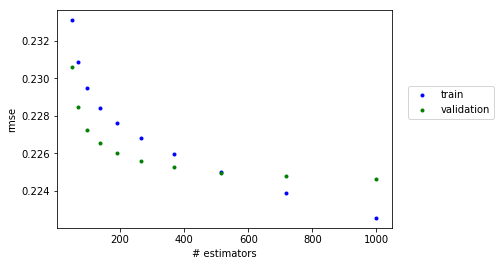

done


In [42]:
#Gradient Boosting for regression

min_n_estim = 50
max_n_estim = 1000
num_steps = 10

n_estim_array = \
np.round(np.exp(np.linspace(np.log(min_n_estim),np.log(max_n_estim),num_steps))).astype(np.int32)

tr_rmses = np.zeros((len(n_estim_array),))
val_rmses = np.zeros((len(n_estim_array),))

for idx,n_estim in enumerate(n_estim_array):
    
    start_time = time.time()
    
    print("\nNow on GB with {:d} estimators...".format(n_estim))

    lgbm_params = {
                   'feature_fraction': 0.5,
                   'metric': 'rmse',
                   'nthread':1, 
                   'min_data_in_leaf': 2**7, 
                   'bagging_fraction': 0.25, 
                   'learning_rate': 0.03, 
                   'objective': 'mse', 
                   'bagging_seed': 2**7, 
                   'num_leaves': 2**7,
                   'bagging_freq':1,
                   'verbose': 0,
                   'max_bin': 2**14
                  }
    
    #fitting for validation
    print("fitting on training records...")
    gbr = lgbm.train(lgbm_params, \
    lgbm.Dataset(net_CSV.loc[tr_val_log_dict['training_logical'],cols], \
    label = net_CSV.loc[tr_val_log_dict['training_logical'],'deal_probability']), n_estim,\
    valid_sets = [lgbm.Dataset(net_CSV.loc[tr_val_log_dict['validation_logical'],cols], 
    label = net_CSV.loc[tr_val_log_dict['validation_logical'],'deal_probability'])],\
    early_stopping_rounds = None,verbose_eval = False)
    
    if True:
        gbr_pred_tr = gbr.predict(net_CSV.loc[tr_val_log_dict['training_logical'],cols]).astype(np.float16)
        gbr_pred_val = gbr.predict(net_CSV.loc[tr_val_log_dict['validation_logical'],cols]).astype(np.float16)
        #gbr_pred_test = gbr.predict(net_CSV.loc[tr_val_log_dict['test_logical'],cols]).astype(np.float16)

        rmse_tr = \
        np.sqrt(((net_CSV.loc[tr_val_log_dict['training_logical'],'deal_probability'] - \
        gbr_pred_tr)**2).mean())
        
        rmse_val = \
        np.sqrt(((net_CSV.loc[tr_val_log_dict['validation_logical'],'deal_probability'] - \
        gbr_pred_val)**2).mean())

        #pd.Series(gbr_pred_test).to_csv(osp.join(results_path,'gbr_pred_test.csv'))

        del gbr_pred_tr,gbr_pred_val
        #,gbr_pred_test
    
        tr_rmses[idx] = rmse_tr
        val_rmses[idx] = rmse_val

        print("rmse for train: {:.6f}".format(rmse_tr))
        print("rmse for validation: {:.6f}".format(rmse_val))

    elapsed_time = time.time() - start_time
    e_min = np.int(np.floor(elapsed_time/60))
    e_sec = np.int(elapsed_time - 60*e_min)
    print("elapsed time = {:d} min {:d} s".format(e_min,e_sec))

plt.show()
plt.xlabel('# estimators')
plt.ylabel('rmse')
plt.plot(n_estim_array,tr_rmses,'.',color = 'b',label = 'train')
plt.plot(n_estim_array,val_rmses,'.',color = 'g',label = 'validation')
plt.legend(loc = (1.05,0.5))
plt.show()

print("done")



In [9]:
def f_LGBM(parameters,one_set_params_flag = False):
    
    if (not(one_set_params_flag)):
        
        parameters = parameters[0]

    lgbm_params = {\
               'feature_fraction': parameters[0],\
               'metric': 'rmse',\
               'nthread':1,\
               'min_data_in_leaf': np.int(parameters[4]),\
               'bagging_fraction': parameters[1],\
               'learning_rate': parameters[2],\
               'objective': 'mse',\
               'bagging_seed': 2**7,\
               'num_leaves': np.int(parameters[3]),\
               'bagging_freq':1,\
               'verbose': 0,\
               'max_bin': 2**14\
              }
    
    #hard code
    n_estim = 500
    early_stopping_rounds = 3
    
    gbr = lgbm.train(lgbm_params, \
    lgbm.Dataset(net_CSV.loc[tr_val_log_dict['training_logical'],cols], \
    label = net_CSV.loc[tr_val_log_dict['training_logical'],'deal_probability']), n_estim,\
    valid_sets = [lgbm.Dataset(net_CSV.loc[tr_val_log_dict['validation_logical'],cols], 
    label = net_CSV.loc[tr_val_log_dict['validation_logical'],'deal_probability'])],\
    early_stopping_rounds = early_stopping_rounds,verbose_eval = False)
    
    gbr_pred_val = gbr.predict(net_CSV.loc[tr_val_log_dict['validation_logical'],cols]).astype(np.float16)

    rmse_val = \
    np.sqrt(((net_CSV.loc[tr_val_log_dict['validation_logical'],'deal_probability'] - \
    gbr_pred_val)**2).mean())
    
    score = np.array(rmse_val)

    return score

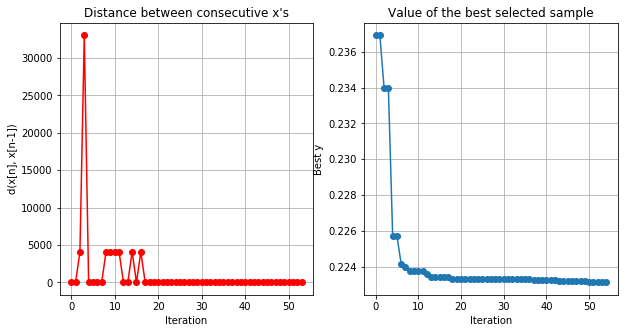

array([6.58021333e-01, 5.99626521e-01, 8.96465506e-03, 4.09600000e+03,
       2.00000000e+00])

In [10]:

# Bounds (NOTE: define continuous variables first, then discrete!)
bounds_LGBM = [
            {'name': 'feature_fraction', 'type': 'continuous', 'domain': (0.3, 0.7)},\
            {'name': 'bagging_fraction', 'type': 'continuous', 'domain': (0.1, 0.6)},\
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (1E-5, 1E-2)},\
            {'name': 'num_leaves', 'type': 'discrete', 'domain': (2**3, 2**12)},\
            {'name': 'min_data_in_leaf', 'type': 'discrete', 'domain': (2, 2**15)}\
            ]

#{'name': 'n_estim', 'type': 'discrete', 'domain': (50, 1E4)}\

np.random.seed(777)
optimizer_LGBM = GPyOpt.methods.BayesianOptimization(f=f_LGBM, domain=bounds_LGBM,\
acquisition_type ='MPI',\
acquisition_par = 0.1,\
exact_eval=True)

max_iter = 50
#max_time = 500
optimizer_LGBM.run_optimization(max_iter)

optimizer_LGBM.plot_convergence()

optimizer_LGBM.X[np.argmin(optimizer_LGBM.Y)]

In [17]:
val_rmse = f_LGBM(np.array([6.58021333e-01, 5.99626521e-01, 8.96465506e-03, 2.00000000e+03,1.00000000e+02]),\
one_set_params_flag = True)

print(val_rmse)



0.22305141484438848


In [23]:
#compute NIMA scores and add to database

#does not need to be redone
if False:
    zip_filename = r"C:\Users\ericz\Documents\AvitoCompetition\data\train_jpg.zip"
    zip_obj = zipfile.ZipFile(zip_filename,mode = 'r') 
    print("created zip object")
    
    
if False:
    zip_filename = r"C:\Users\ericz\Documents\AvitoCompetition\data\test_jpg.zip"
    zip_obj = zipfile.ZipFile(zip_filename,mode = 'r') 
    print("created zip object")
    #remember to close!
    #zip_obj.close()
    
if False:
    NIMA_model = load_NIMA()
    print("loaded NIMA")


add_NIMA_score_to_database(net_CSV,train_CSV_flag = True, \
zip_obj = zip_obj,NIMA_model = NIMA_model,batch_size = 10,\
break_at = np.inf,\
save_interval = np.int(1E4),\
idx_start = 1503424,idx_end_exclusive = None)

if False:
    if True:
        amin = train_CSV.loc[:99,'NIMA_mean'].argmin()
        jpg_id = train_CSV.loc[amin,'image']
    else:
        amax = train_CSV.loc[:99,'NIMA_mean'].argmax()
        jpg_id = train_CSV.loc[amax,'image']
    
    extract_jpg_from_zipfileobject(zip_obj,jpg_id,verbose = False)



Adding NIMA fieldnames to database...
Done.
Starting computation of NIMA metrics...


HBox(children=(IntProgress(value=0, max=508438), HTML(value='')))

C:\Users\ericz\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)



Time elapsed  = 240756.2 seconds
Done.


In [82]:
#compute onject classification vectors and save them as individual PKL files

#does not need to be redone
if False:
    zip_filename = r"C:\Users\ericz\Documents\AvitoCompetition\data\train_jpg.zip"
    zip_obj = zipfile.ZipFile(zip_filename,mode = 'r') 
    print("created zip object")
    train_CSV_flag = True
    
    
if False:
    zip_filename = r"C:\Users\ericz\Documents\AvitoCompetition\data\test_jpg.zip"
    zip_obj = zipfile.ZipFile(zip_filename,mode = 'r') 
    print("created zip object")
    train_CSV_flag = False
    #remember to close!
    #zip_obj.close()
    
if True:
    #object_classification_model = load_InceptionResNetV2()
    object_classification_model = load_VGG19()
    print("loaded object_classification_model")


    
#InceptionResNetV2
#target_size = (299,299)

#VGG19
target_size = (224,224)
    
save_object_classification_vectors(net_CSV, tr_val_log_dict,\
target_size = target_size, train_CSV_flag = train_CSV_flag,\
zip_obj = zip_obj,object_classification_model = object_classification_model,\
batch_size = 10,break_at = np.inf,\
idx_start = 0,idx_end_exclusive = None)

#extract_jpg_from_zipfileobject(zip_obj,jpg_id,verbose = False)


385646592/574710816 [===================>..........] - ETA: 1:42:3 - ETA: 1:09:1 - ETA: 1:02:2 - ETA: 47:01  - ETA: 40:4 - ETA: 37:3 - ETA: 33:4 - ETA: 30:1 - ETA: 25:4 - ETA: 23:3 - ETA: 20:1 - ETA: 17:5 - ETA: 16:0 - ETA: 14:0 - ETA: 12:2 - ETA: 10:3 - ETA: 10:3 - ETA: 9:1 - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ET

HBox(children=(IntProgress(value=0, max=1503424), HTML(value='')))

Time elapsed  = 700388.7 seconds
Done.


In [81]:
del object_classification_model

In [ ]:
if False:
    zip_filename = r"C:\Users\ericz\Documents\AvitoCompetition\data\train_jpg.zip"
    zip_obj = zipfile.ZipFile(zip_filename,mode = 'r') 
else:
    zip_obj.close()

In [27]:
jpg_id_list = \
["1262fadc0dc195fb021235cade2b37e09134b3d6a5012028d9047335afadfc94"]

object_classification_vector_list = load_object_classification_vectors(jpg_id_list)

#extract_jpg_from_zipfileobject(zip_obj,jpg_id_list[0],verbose = False)

decode_predictions(object_classification_vector_list[0].reshape(1,-1))

[[('n03388549', 'four-poster', 0.24008057),
  ('n04344873', 'studio_couch', 0.2296804),
  ('n04239074', 'sliding_door', 0.09342557),
  ('n03788365', 'mosquito_net', 0.09014095),
  ('n04590129', 'window_shade', 0.05248477)]]

In [42]:
categorical_vars_to_encode = ['param_1','param_2','param_3']

add_1way_meanencodings(net_CSV,categorical_vars_to_encode,\
tr_val_log_dict,mean_fill_flag = False)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

C:\Users\ericz\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)



done


In [47]:
#add day of week field to database

if 0:
    add_day_of_week_field(train_CSV)
else:
    add_day_of_week_field(test_CSV)
    
print("done")

done


In [75]:
#save databases to CSV
net_CSV.to_csv(r'C:\Users\ericz\Documents\AvitoCompetition\data\processed_net.csv',index = False)
#test_CSV.to_csv(r'C:\Users\ericz\Documents\AvitoCompetition\data\processed_test.csv')
#train_CSV.to_csv(r'C:\Users\ericz\Documents\AvitoCompetition\data\processed_train.csv')

In [40]:
net_CSV.drop(labels = ['ME_param_1','ME_param_2','ME_param_3'],axis = 1,inplace = True) 

In [24]:
report_na(net_CSV,verbose_columns = [])


# (%) nulls for column NIMA_mean = 155201 (7.71%); # unique values = 1847579

# (%) nulls for column NIMA_sd = 155201 (7.71%); # unique values = 1847754

# (%) nulls for column activation_date = 0 (0.00%); # unique values = 30

# (%) nulls for column category_name = 0 (0.00%); # unique values = 47

# (%) nulls for column city = 0 (0.00%); # unique values = 1752

# (%) nulls for column day_of_week = 0 (0.00%); # unique values = 7

# (%) nulls for column deal_probability = 508438 (25.27%); # unique values = 18408

# (%) nulls for column description = 116276 (5.78%); # unique values = 1794802

# (%) nulls for column description_processed = 116578 (5.79%); # unique values = 1784344

# (%) nulls for column description_processed_length = 508438 (25.27%); # unique values = 928

# (%) nulls for column image = 155197 (7.71%); # unique values = 1856666

# (%) nulls for column image_top_1 = 155197 (7.71%); # unique values = 3064

# (%) nulls for column item_id = 0 (0.00%); # unique values = 2011

In [40]:
print(net_CSV['user_type'].unique().shape)
print(net_CSV.shape)
print(net_CSV.loc[0,'category_name'])
print(net_CSV.loc[0,'parent_category_name'])


(3,)
(2011862, 36)
Товары для детей и игрушки
Личные вещи


In [11]:
train_active_csv = load_active_CSV(os.path.join(AVITO_DATA_DIR,'train_active.csv'),nrows = 10,skiprows = 0)
net_CSV = load_main_CSV(os.path.join(AVITO_DATA_DIR,'processed_net.csv'),nrows = 10)

loading C:\Users\ericz\Documents\AvitoCompetition\data\processed_net.csv...


In [50]:
preprocess_fields_for_tokenizing(test_CSV,fieldnames_to_preprocess = ['description','title'])

Now pre-processing fieldname: title


HBox(children=(IntProgress(value=0, max=508438), HTML(value='')))

C:\Users\ericz\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)




% of tokens in embedding = 90.53
time elapsed = 1005.7 s


In [10]:
def compare_columns(database1,database2):
    """
    Creates dataframe which indicates whether the union of the fieldnames of the
    competition train and test CSVs are present in each.
    """
    
    database1_columns = list(database1.columns.values)
    database2_columns = list(database2.columns.values)
    
    net_columns = list(set(database1_columns).union(set(database2_columns)))
    
    num_net_columns = len(net_columns)
    
    columns_present_db = pd.DataFrame({'column_name': num_net_columns*[None],\
    'in_database1':num_net_columns*[None],\
    'in_database2':num_net_columns*[None]})
    
    for idx,col in enumerate(net_columns):
        
        columns_present_db.loc[idx,'column_name'] = col
        columns_present_db.loc[idx,'in_database1'] = col in database1_columns
        columns_present_db.loc[idx,'in_database2'] = col in database2_columns
        
    return columns_present_db
        
        
    
    

In [12]:
columns_present_db = compare_columns(net_CSV,train_active_csv)
print(columns_present_db)

                       column_name in_database1 in_database2
0                tokenized_param_3         True        False
1                           region         True         True
2                        NIMA_mean         True        False
3                       ME_param_2         True        False
4                   ME_day_of_week         True        False
5                      image_top_1         True        False
6     description_processed_length         True        False
7                  title_processed         True        False
8                          param_2         True         True
9                          item_id         True         True
10               tokenized_param_1         True        False
11              ME_item_seq_number         True        False
12                    ME_user_type         True        False
13                         param_3         True         True
14                           price         True         True
15  tokenized_parent_cat

In [54]:
net_CSV = pd.concat([train_CSV,test_CSV],ignore_index = True,axis = 0)

In [ ]:
try:
    del train_CSV
    print("deleted train_CSV")
except:
    pass
try:
    del test_CSV
    print("deleted test_CSV")
except:
    pass

In [ ]:
translator= Translator(to_lang="en",from_lang = "ru")

In [ ]:
translator.translate('Волгоградская область')

In [ ]:
text = '\n'
print(translator.translate(text))
'in dict' if word_to_glove_vec.get(text) is not None else "not in dict"